In [1]:
import torch
import torch.nn.functional as F
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import tifffile as tiff
import cv2

In [2]:
path = Path("../")
data_path = path / "data"
os.listdir(data_path)

['train_images',
 'test_images',
 'train_annotations',
 'train.csv',
 'sample_submission.csv',
 'test.csv']

In [3]:
train_images_path = data_path / "train_images"

In [4]:
train_df = pd.read_csv(data_path / "train.csv")
train_df['path'] = train_df.id.apply(lambda x: f'{str(train_images_path)}/{x}.tiff')
train_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,path
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../data/train_images/10044.tiff
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../data/train_images/10274.tiff
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../data/train_images/10392.tiff
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../data/train_images/10488.tiff
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../data/train_images/10610.tiff


## UNet from scratch

In [5]:
number_of_classes = 2 # 2 classes
number_of_channels = 3

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=number_of_classes, in_ch=number_of_channels, log=False):
        super().__init__()

        self.log = log

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        if self.log:
            print('\t\tinput shape: ', x.shape)
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

## Dice coefficient loss

In [6]:
def dice_coeff(pred, target):
    smooth = 1.
    num = pred.size(1)
    m1 = pred.view(num, -1).float()  # Flatten
    m2 = target.view(num, -1).float()  # Flatten
    intersection = (m1 * m2).sum().float()
    dice = (2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth)
    dice = dice.item()

    return dice

## Train all images

In [7]:
def rle2mask(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [
        np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])
    ]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo : hi] = 1
    if len(shape) == 3:
        img = img.reshape(shape[0], shape[1])
    else:
        img = img.reshape(shape[0], shape[1])
    return img.T

In [8]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, dataframe, n_classes=2, dim=2000, interpolation=cv2.INTER_LANCZOS4):
    self.dataframe = dataframe
    self.n_classes = n_classes
    self.dim = dim
    self.interpolation = interpolation

  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self, ix):
    # Get image path from column 'path' in dataframe
    img_path = str(self.dataframe.iloc[ix]['path'])
    # Load image
    img_cv = cv2.imread(img_path)
    img_cv = cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB)
    # Resize image
    img_cv_res = cv2.resize(img_cv, dsize=(self.dim, self.dim), interpolation=self.interpolation)
    # Normalize image
    img_cv_res_norm = img_cv_res / 255.0
    # Convert to tensor
    img_tensor = torch.from_numpy(img_cv_res_norm).float().permute(2, 0, 1)

    # Get mask
    rle = self.dataframe.iloc[ix]['rle']
    mask_cv = rle2mask(rle, img_cv.shape)
    # Resize mask
    mask_cv_res = cv2.resize(mask_cv, dsize=(self.dim, self.dim), interpolation=self.interpolation)
    # One-hot encode mask
    mask_oh = np.eye(2)[mask_cv_res.astype(int)].astype(np.float32)
    # Convert to tensor
    mask_tensor = torch.from_numpy(mask_oh).float().permute(2, 0, 1)
    
    return img_tensor, mask_tensor

In [9]:
division = 300
resize_img = 800
dataset = {
    'train': Dataset(train_df[:division], n_classes=2, dim=resize_img),
    'val': Dataset(train_df[division:], n_classes=2, dim=resize_img),
}

print(f"Había {len(train_df)} imágenes en el dataset, lo hemos dividido en {len(dataset['train'])} imágenes de entrenamiento y {len(dataset['val'])} imágenes de validación")

Había 351 imágenes en el dataset, lo hemos dividido en 300 imágenes de entrenamiento y 51 imágenes de validación


In [10]:
BS_train = 10
BS_val = 16
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=BS_train, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['val'], batch_size=BS_val, pin_memory=True)
}

In [11]:
from tqdm import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, dataloader, epochs=100, lr=3e-4, parallel=False):
    len_int_epochs = len(str(epochs))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    if torch.cuda.device_count() >= 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        if parallel:
            model = torch.nn.DataParallel(model)
        model.cuda()
    else:
        print("Let's use CPU!")
        model.to(device)
    hist = {'loss': [], 'dice': [], 'test_loss': [], 'test_dice': []}
    for epoch in range(epochs):
        bar = tqdm(dataloader['train'])
        train_loss, train_dice = [], []
        model.train()
        for imgs, masks in bar:
            imgs, masks = imgs.to(device), masks.to(device)
            optimizer.zero_grad()
            pred_mask = model(imgs)
            loss = criterion(pred_mask, masks)
            loss.backward()
            optimizer.step()
            dice = dice_coeff(pred_mask, masks)
            train_loss.append(loss.item())
            train_dice.append(dice)
            bar.set_description(f"\t\tloss {np.mean(train_loss):.5f}, dice {np.mean(train_dice):.5f}")
        hist['loss'].append(np.mean(train_loss))
        hist['dice'].append(np.mean(train_dice))
        bar = tqdm(dataloader['test'])
        test_loss, test_dice = [], []
        model.eval()
        with torch.no_grad():
            for imgs, masks in bar:
                imgs, masks = imgs.to(device), masks.to(device)
                pred_mask = model(imgs)
                loss = criterion(pred_mask, masks)
                dice = dice_coeff(pred_mask, masks)
                test_loss.append(loss.item())
                test_dice.append(dice)
                bar.set_description(f"\t\ttest_loss {np.mean(test_loss):.5f} test_dice {np.mean(test_dice):.5f}")
        hist['test_loss'].append(np.mean(test_loss))
        hist['test_dice'].append(np.mean(test_dice))
        if len_int_epochs == 1:
            print(f"Epoch {(epoch+1):01d}/{epochs:01d} loss {np.mean(train_loss):.5f} dice {np.mean(train_dice):.5f} test_loss {np.mean(test_loss):.5f} test_dice {np.mean(test_dice):.5f}")
        elif len_int_epochs == 2:
            print(f"Epoch {(epoch+1):02d}/{epochs:02d} loss {np.mean(train_loss):.5f} dice {np.mean(train_dice):.5f} test_loss {np.mean(test_loss):.5f} test_dice {np.mean(test_dice):.5f}")
        elif len_int_epochs == 3:
            print(f"Epoch {(epoch+1):03d}/{epochs:03d} loss {np.mean(train_loss):.5f} dice {np.mean(train_dice):.5f} test_loss {np.mean(test_loss):.5f} test_dice {np.mean(test_dice):.5f}")
        elif len_int_epochs == 4:
            print(f"Epoch {(epoch+1):04d}/{epochs:04d} loss {np.mean(train_loss):.5f} dice {np.mean(train_dice):.5f} test_loss {np.mean(test_loss):.5f} test_dice {np.mean(test_dice):.5f}")
    return hist

In [12]:
model = UNet()
EPOCHS = 100
LR = 3e-4
hist = fit(model, dataloader, epochs=EPOCHS, lr=LR, parallel=True)

Let's use 2 GPUs!


		test_loss 0.44735 test_dice 1.25801: 100%|██████████| 4/4 [00:05<00:00,  1.27s/it]


Epoch 001/100 loss 0.50362 dice 1.02278 test_loss 0.44735 test_dice 1.25801


		test_loss 0.32387 test_dice 2.19492: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


Epoch 002/100 loss 0.36343 dice 1.91945 test_loss 0.32387 test_dice 2.19492


		test_loss 0.28576 test_dice 2.77339: 100%|██████████| 4/4 [00:04<00:00,  1.25s/it]


Epoch 003/100 loss 0.29411 dice 2.63794 test_loss 0.28576 test_dice 2.77339


		test_loss 0.24160 test_dice 3.34192: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 004/100 loss 0.25862 dice 3.23332 test_loss 0.24160 test_dice 3.34192


		test_loss 0.22060 test_dice 4.06568: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 005/100 loss 0.23798 dice 3.72992 test_loss 0.22060 test_dice 4.06568


		test_loss 0.21529 test_dice 4.08542: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


Epoch 006/100 loss 0.22308 dice 4.15300 test_loss 0.21529 test_dice 4.08542


		test_loss 0.25256 test_dice 3.92844: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 007/100 loss 0.21609 dice 4.50772 test_loss 0.25256 test_dice 3.92844


		test_loss 0.24926 test_dice 4.71356: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 008/100 loss 0.20726 dice 4.81223 test_loss 0.24926 test_dice 4.71356


		test_loss 0.19211 test_dice 5.35530: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Epoch 009/100 loss 0.19747 dice 5.11569 test_loss 0.19211 test_dice 5.35530


		test_loss 0.18100 test_dice 6.21544: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


Epoch 010/100 loss 0.19532 dice 5.36066 test_loss 0.18100 test_dice 6.21544


		test_loss 0.18762 test_dice 6.63999: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 011/100 loss 0.20133 dice 5.56180 test_loss 0.18762 test_dice 6.63999


		test_loss 0.18754 test_dice 6.25128: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


Epoch 012/100 loss 0.18504 dice 5.79514 test_loss 0.18754 test_dice 6.25128


		test_loss 0.17818 test_dice 6.45278: 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


Epoch 013/100 loss 0.18334 dice 5.92765 test_loss 0.17818 test_dice 6.45278


		test_loss 0.20443 test_dice 6.30589: 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


Epoch 014/100 loss 0.18209 dice 6.11477 test_loss 0.20443 test_dice 6.30589


		test_loss 0.17862 test_dice 6.54465: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


Epoch 015/100 loss 0.17909 dice 6.25589 test_loss 0.17862 test_dice 6.54465


		test_loss 0.17073 test_dice 6.71352: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


Epoch 016/100 loss 0.17642 dice 6.44641 test_loss 0.17073 test_dice 6.71352


		test_loss 0.16594 test_dice 6.22240: 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


Epoch 017/100 loss 0.17665 dice 6.54589 test_loss 0.16594 test_dice 6.22240


		test_loss 0.18134 test_dice 6.01410: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


Epoch 018/100 loss 0.17003 dice 6.67238 test_loss 0.18134 test_dice 6.01410


		test_loss 0.19174 test_dice 6.74889: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


Epoch 019/100 loss 0.16114 dice 6.79881 test_loss 0.19174 test_dice 6.74889


		test_loss 0.17758 test_dice 8.24999: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 020/100 loss 0.16091 dice 6.98999 test_loss 0.17758 test_dice 8.24999


		test_loss 0.16593 test_dice 7.63486: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


Epoch 021/100 loss 0.16254 dice 7.06811 test_loss 0.16593 test_dice 7.63486


		test_loss 0.19808 test_dice 6.10343: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


Epoch 022/100 loss 0.15275 dice 7.20830 test_loss 0.19808 test_dice 6.10343


		test_loss 0.15688 test_dice 6.65753: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


Epoch 023/100 loss 0.15623 dice 7.28227 test_loss 0.15688 test_dice 6.65753


		test_loss 0.15156 test_dice 8.41334: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


Epoch 024/100 loss 0.15387 dice 7.39897 test_loss 0.15156 test_dice 8.41334


		test_loss 0.17248 test_dice 8.30906: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Epoch 025/100 loss 0.15043 dice 7.50870 test_loss 0.17248 test_dice 8.30906


		test_loss 0.19516 test_dice 6.73852: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 026/100 loss 0.14851 dice 7.60584 test_loss 0.19516 test_dice 6.73852


		test_loss 0.18099 test_dice 8.14021: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Epoch 027/100 loss 0.14241 dice 7.72711 test_loss 0.18099 test_dice 8.14021


		test_loss 0.20023 test_dice 6.83505: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


Epoch 028/100 loss 0.14183 dice 7.79779 test_loss 0.20023 test_dice 6.83505


		test_loss 0.17504 test_dice 7.50882: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


Epoch 029/100 loss 0.14472 dice 7.88254 test_loss 0.17504 test_dice 7.50882


		test_loss 0.17410 test_dice 6.86121: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


Epoch 030/100 loss 0.14363 dice 8.04204 test_loss 0.17410 test_dice 6.86121


		test_loss 0.17930 test_dice 7.35768: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 031/100 loss 0.14226 dice 8.02502 test_loss 0.17930 test_dice 7.35768


		test_loss 0.14792 test_dice 7.86377: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Epoch 032/100 loss 0.13685 dice 8.10883 test_loss 0.14792 test_dice 7.86377


		test_loss 0.19497 test_dice 7.04446: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


Epoch 033/100 loss 0.13644 dice 8.22796 test_loss 0.19497 test_dice 7.04446


		test_loss 0.13790 test_dice 8.96381: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 034/100 loss 0.13201 dice 8.27885 test_loss 0.13790 test_dice 8.96381


		test_loss 0.14384 test_dice 7.98319: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Epoch 035/100 loss 0.13053 dice 8.33340 test_loss 0.14384 test_dice 7.98319


		test_loss 0.14252 test_dice 8.84887: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


Epoch 036/100 loss 0.12774 dice 8.41407 test_loss 0.14252 test_dice 8.84887


		test_loss 0.14031 test_dice 7.75417: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 037/100 loss 0.12912 dice 8.51460 test_loss 0.14031 test_dice 7.75417


		test_loss 0.18661 test_dice 8.33698: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


Epoch 038/100 loss 0.12986 dice 8.58595 test_loss 0.18661 test_dice 8.33698


		test_loss 0.13165 test_dice 8.69618: 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


Epoch 039/100 loss 0.13092 dice 8.61116 test_loss 0.13165 test_dice 8.69618


		test_loss 0.16827 test_dice 9.07045: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


Epoch 040/100 loss 0.13157 dice 8.66618 test_loss 0.16827 test_dice 9.07045


		test_loss 0.15122 test_dice 8.00277: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


Epoch 041/100 loss 0.12935 dice 8.73161 test_loss 0.15122 test_dice 8.00277


		test_loss 0.15184 test_dice 9.57131: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 042/100 loss 0.12792 dice 8.81525 test_loss 0.15184 test_dice 9.57131


		test_loss 0.19147 test_dice 9.03269: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


Epoch 043/100 loss 0.12252 dice 8.82497 test_loss 0.19147 test_dice 9.03269


		test_loss 0.13341 test_dice 8.96431: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 044/100 loss 0.11961 dice 8.94743 test_loss 0.13341 test_dice 8.96431


		test_loss 0.20698 test_dice 8.09452: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Epoch 045/100 loss 0.12072 dice 9.05512 test_loss 0.20698 test_dice 8.09452


		test_loss 0.14112 test_dice 9.67381: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 046/100 loss 0.11860 dice 9.10697 test_loss 0.14112 test_dice 9.67381


		test_loss 0.14010 test_dice 9.59987: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 047/100 loss 0.12064 dice 9.18620 test_loss 0.14010 test_dice 9.59987


		test_loss 0.12674 test_dice 9.43882: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 048/100 loss 0.11265 dice 9.24666 test_loss 0.12674 test_dice 9.43882


		test_loss 0.16138 test_dice 9.03722: 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]


Epoch 049/100 loss 0.11217 dice 9.30204 test_loss 0.16138 test_dice 9.03722


		test_loss 0.20759 test_dice 8.53752: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 050/100 loss 0.12247 dice 9.32702 test_loss 0.20759 test_dice 8.53752


		test_loss 0.12862 test_dice 9.48609: 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


Epoch 051/100 loss 0.11990 dice 9.47159 test_loss 0.12862 test_dice 9.48609


		test_loss 0.16351 test_dice 11.16304: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 052/100 loss 0.11069 dice 9.53051 test_loss 0.16351 test_dice 11.16304


		test_loss 0.13815 test_dice 8.33423: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 053/100 loss 0.11189 dice 9.54056 test_loss 0.13815 test_dice 8.33423


		test_loss 0.13383 test_dice 8.92420: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


Epoch 054/100 loss 0.11320 dice 9.54617 test_loss 0.13383 test_dice 8.92420


		test_loss 0.14930 test_dice 9.64451: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


Epoch 055/100 loss 0.11429 dice 9.63072 test_loss 0.14930 test_dice 9.64451


		test_loss 0.12247 test_dice 8.36530: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Epoch 056/100 loss 0.11048 dice 9.71476 test_loss 0.12247 test_dice 8.36530


		test_loss 0.22756 test_dice 8.15662: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


Epoch 057/100 loss 0.11051 dice 9.79558 test_loss 0.22756 test_dice 8.15662


		test_loss 0.14286 test_dice 9.18645: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 058/100 loss 0.10725 dice 9.75637 test_loss 0.14286 test_dice 9.18645


		test_loss 0.11906 test_dice 8.83179: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 059/100 loss 0.10241 dice 9.88293 test_loss 0.11906 test_dice 8.83179


		test_loss 0.13449 test_dice 9.24207: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 060/100 loss 0.10493 dice 9.93253 test_loss 0.13449 test_dice 9.24207


		test_loss 0.14268 test_dice 10.61667: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 061/100 loss 0.10448 dice 9.96480 test_loss 0.14268 test_dice 10.61667


		test_loss 0.19596 test_dice 9.77569: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it] 


Epoch 062/100 loss 0.10361 dice 10.00327 test_loss 0.19596 test_dice 9.77569


		test_loss 0.14967 test_dice 10.41877: 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


Epoch 063/100 loss 0.10279 dice 10.03773 test_loss 0.14967 test_dice 10.41877


		test_loss 0.14885 test_dice 11.08584: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


Epoch 064/100 loss 0.10720 dice 10.14601 test_loss 0.14885 test_dice 11.08584


		test_loss 0.14830 test_dice 9.70652: 100%|██████████| 4/4 [00:04<00:00,  1.23s/it] 


Epoch 065/100 loss 0.10276 dice 10.12535 test_loss 0.14830 test_dice 9.70652


		test_loss 0.14884 test_dice 9.80929: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 066/100 loss 0.10076 dice 10.26620 test_loss 0.14884 test_dice 9.80929


		test_loss 0.12685 test_dice 11.22291: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


Epoch 067/100 loss 0.10082 dice 10.31923 test_loss 0.12685 test_dice 11.22291


		test_loss 0.11348 test_dice 10.13646: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 068/100 loss 0.09675 dice 10.40236 test_loss 0.11348 test_dice 10.13646


		test_loss 0.15864 test_dice 8.42036: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 069/100 loss 0.09890 dice 10.39312 test_loss 0.15864 test_dice 8.42036


		test_loss 0.12629 test_dice 9.56183: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 070/100 loss 0.10045 dice 10.43937 test_loss 0.12629 test_dice 9.56183


		test_loss 0.14888 test_dice 11.39836: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


Epoch 071/100 loss 0.09519 dice 10.51306 test_loss 0.14888 test_dice 11.39836


		test_loss 0.13417 test_dice 11.95865: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


Epoch 072/100 loss 0.09103 dice 10.60616 test_loss 0.13417 test_dice 11.95865


		test_loss 0.12894 test_dice 11.25241: 100%|██████████| 4/4 [00:04<00:00,  1.19s/it]


Epoch 073/100 loss 0.08955 dice 10.65938 test_loss 0.12894 test_dice 11.25241


		test_loss 0.13494 test_dice 10.65154: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Epoch 074/100 loss 0.09265 dice 10.68227 test_loss 0.13494 test_dice 10.65154


		test_loss 0.13575 test_dice 9.09956: 100%|██████████| 4/4 [00:04<00:00,  1.15s/it]


Epoch 075/100 loss 0.09642 dice 10.73858 test_loss 0.13575 test_dice 9.09956


		test_loss 0.13430 test_dice 11.75535: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 076/100 loss 0.09219 dice 10.83250 test_loss 0.13430 test_dice 11.75535


		test_loss 0.12835 test_dice 11.52177: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


Epoch 077/100 loss 0.09478 dice 10.88914 test_loss 0.12835 test_dice 11.52177


		test_loss 0.11763 test_dice 11.44033: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Epoch 078/100 loss 0.08552 dice 10.97485 test_loss 0.11763 test_dice 11.44033


		test_loss 0.14344 test_dice 8.48915: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Epoch 079/100 loss 0.09686 dice 10.95142 test_loss 0.14344 test_dice 8.48915


		test_loss 0.13463 test_dice 11.29983: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


Epoch 080/100 loss 0.08946 dice 10.98764 test_loss 0.13463 test_dice 11.29983


		test_loss 0.15944 test_dice 9.44406: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


Epoch 081/100 loss 0.08942 dice 11.05439 test_loss 0.15944 test_dice 9.44406


		test_loss 0.12604 test_dice 11.31526: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]


Epoch 082/100 loss 0.08953 dice 11.12185 test_loss 0.12604 test_dice 11.31526


		test_loss 0.17519 test_dice 11.77155: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


Epoch 083/100 loss 0.08242 dice 11.31743 test_loss 0.17519 test_dice 11.77155


		test_loss 0.12378 test_dice 10.37573: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 084/100 loss 0.08980 dice 11.25366 test_loss 0.12378 test_dice 10.37573


		test_loss 0.12750 test_dice 12.54778: 100%|██████████| 4/4 [00:05<00:00,  1.27s/it]


Epoch 085/100 loss 0.08355 dice 11.36611 test_loss 0.12750 test_dice 12.54778


		test_loss 0.13465 test_dice 10.76895: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Epoch 086/100 loss 0.08300 dice 11.34925 test_loss 0.13465 test_dice 10.76895


		test_loss 0.12982 test_dice 9.91431: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it] 


Epoch 087/100 loss 0.08890 dice 11.38917 test_loss 0.12982 test_dice 9.91431


		test_loss 0.14633 test_dice 9.66468: 100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


Epoch 088/100 loss 0.08858 dice 11.40725 test_loss 0.14633 test_dice 9.66468


		test_loss 0.16328 test_dice 9.77077: 100%|██████████| 4/4 [00:04<00:00,  1.25s/it]


Epoch 089/100 loss 0.08195 dice 11.44197 test_loss 0.16328 test_dice 9.77077


		test_loss 0.16788 test_dice 12.58277: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


Epoch 090/100 loss 0.08563 dice 11.54689 test_loss 0.16788 test_dice 12.58277


		test_loss 0.14934 test_dice 11.79933: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Epoch 091/100 loss 0.08455 dice 11.42032 test_loss 0.14934 test_dice 11.79933


		test_loss 0.14806 test_dice 10.87610: 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


Epoch 092/100 loss 0.08235 dice 11.45329 test_loss 0.14806 test_dice 10.87610


		test_loss 0.12215 test_dice 11.60109: 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


Epoch 093/100 loss 0.08369 dice 11.53034 test_loss 0.12215 test_dice 11.60109


		test_loss 0.12681 test_dice 10.85615: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


Epoch 094/100 loss 0.07948 dice 11.62937 test_loss 0.12681 test_dice 10.85615


		test_loss 0.15604 test_dice 12.64335: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


Epoch 095/100 loss 0.07689 dice 11.76131 test_loss 0.15604 test_dice 12.64335


		test_loss 0.19168 test_dice 10.80262: 100%|██████████| 4/4 [00:04<00:00,  1.20s/it]


Epoch 096/100 loss 0.07621 dice 11.77710 test_loss 0.19168 test_dice 10.80262


		test_loss 0.12690 test_dice 12.25318: 100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


Epoch 097/100 loss 0.07904 dice 11.85345 test_loss 0.12690 test_dice 12.25318


		test_loss 0.13030 test_dice 11.48968: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]


Epoch 098/100 loss 0.07533 dice 11.90225 test_loss 0.13030 test_dice 11.48968


		test_loss 0.13713 test_dice 9.96132: 100%|██████████| 4/4 [00:04<00:00,  1.25s/it] 


Epoch 099/100 loss 0.07294 dice 12.02005 test_loss 0.13713 test_dice 9.96132


		test_loss 0.14588 test_dice 11.89380: 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]

Epoch 100/100 loss 0.07616 dice 12.05587 test_loss 0.14588 test_dice 11.89380


In [13]:
model_path = path / 'models' / '02_unet_custom_DataParallel.zip'
torch.jit.save(torch.jit.script(model.cpu()), model_path)

In [14]:
hist_df = pd.DataFrame(hist)
print(len(hist_df))
hist_df.head()

100


,loss,dice,test_loss,test_dice
0,0.503624,1.022777,0.447345,1.258010
1,0.363429,1.919454,0.323874,2.194918
2,0.294111,2.637937,0.285761,2.773387
3,0.258619,3.233319,0.241604,3.341923
4,0.237979,3.729917,0.220598,4.065678


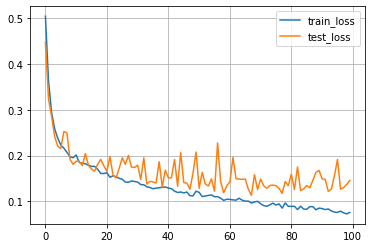

In [15]:
# plot the training and testing loss
plt.plot(hist['loss'], label='train_loss')
plt.plot(hist['test_loss'], label='test_loss')
plt.legend()
plt.grid()
plt.show()

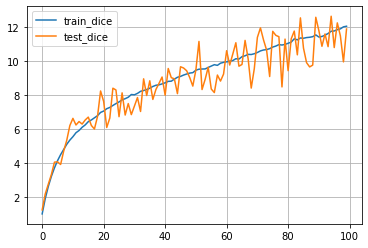

In [16]:
# plot the training and testing dice
plt.plot(hist['dice'], label='train_dice')
plt.plot(hist['test_dice'], label='test_dice')
plt.legend()
plt.grid()
plt.show()

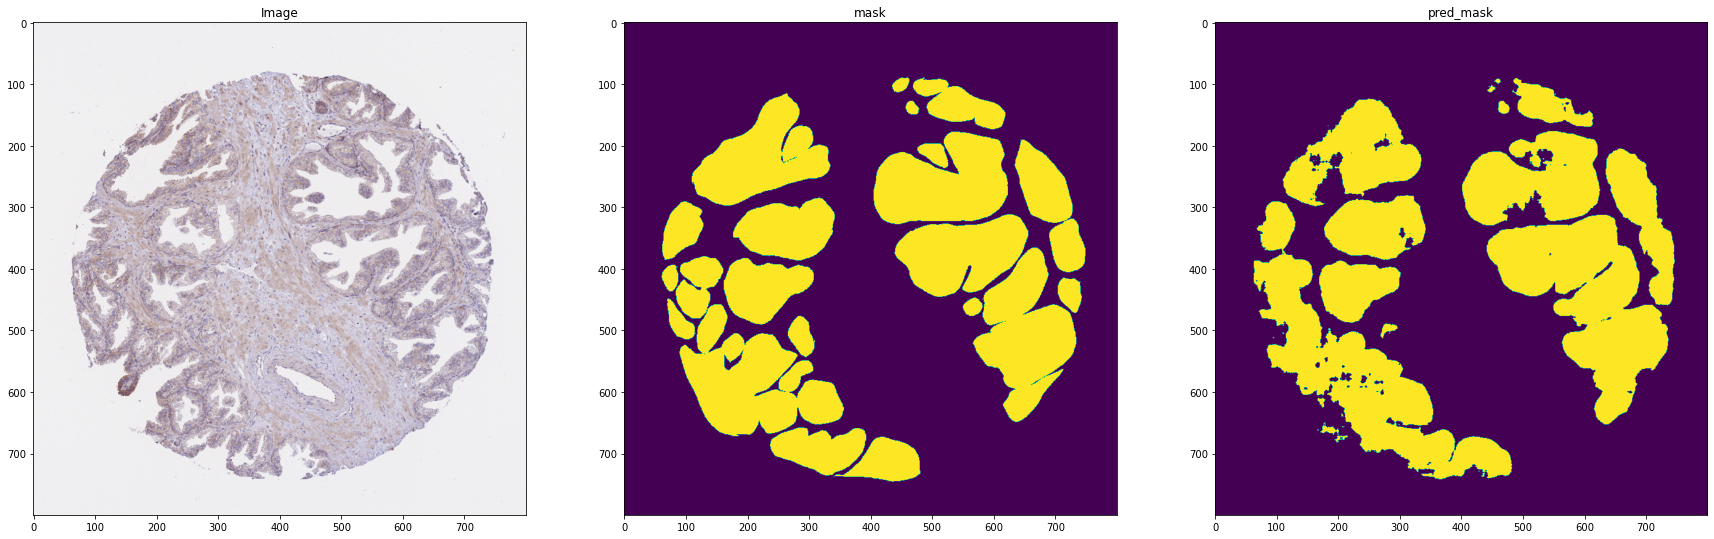

output.shape = torch.Size([2, 800, 800]), pred_mask.shape = torch.Size([800, 800])


In [17]:
sample_val_img, sample_val_mask = next(iter(dataloader['test']))
one_sample_img = sample_val_img[0]
one_sample_mask = sample_val_mask[0]
model.eval()
with torch.no_grad():
    output = model(sample_val_img)[0]
    pred_mask = torch.argmax(output, axis=0)
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(one_sample_img.permute(1, 2, 0).cpu().numpy())
ax1.set_title('Image')
ax2.imshow(torch.argmax(one_sample_mask, axis=0).cpu().numpy())
ax2.set_title('mask')
ax3.imshow(pred_mask.squeeze().cpu().numpy())
ax3.set_title('pred_mask')
plt.show()
print(f"output.shape = {output.shape}, pred_mask.shape = {pred_mask.shape}")